In [1]:
#Importall neccesary libraries required for this module

import tensorflow as tf
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
#from keras.utils.visualize_util import plot
from keras.utils.np_utils import to_categorical
import  numpy as np
import  matplotlib.pyplot as plt
import  sklearn
from    sklearn import datasets, linear_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, UpSampling2D


Using TensorFlow backend.


### Defining the functions below to generate shapes and training and test datasets

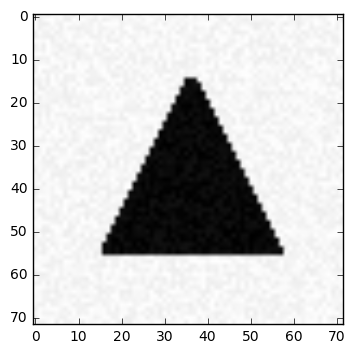

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [4]:
X_train.shape

(300, 5184)

In [5]:
Y_train.shape

(300,)

In [6]:
#Converting Y-train to categorical variables
Y_train_categorical=to_categorical(Y_train)

In [7]:
Y_train[0:5]

array([2., 1., 2., 1., 1.])

In [8]:
Y_train_categorical[0:5]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### We will now implement 2 optimizer functions. Adam and SGD and we will how different they are

In [13]:
#Using SGD optimizer first
from keras.optimizers import SGD,Adam

sgd = SGD(lr=0.001,decay=1e-6, momentum=0.9,nesterov=False)
model = Sequential()
model.add(Dense(100,activation="tanh",input_shape=(5184,)))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [14]:
# Train
np.random.seed(3)
model.fit(X_train, Y_train_categorical, nb_epoch=15, batch_size=70)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Epoch 1/15
300/300 [==============================] - 0s 970us/step - loss: 1.4400 - acc: 0.3400
Epoch 2/15
300/300 [==============================] - 0s 207us/step - loss: 1.0512 - acc: 0.4400
Epoch 3/15
300/300 [==============================] - 0s 193us/step - loss: 0.8562 - acc: 0.6233
Epoch 4/15
300/300 [==============================] - 0s 193us/step - loss: 0.7526 - acc: 0.6700
Epoch 5/15
300/300 [==============================] - 0s 200us/step - loss: 0.6879 - acc: 0.6933
Epoch 6/15
300/300 [==============================] - 0s 193us/step - loss: 0.6259 - acc: 0.7367
Epoch 7/15
300/300 [==============================] - 0s 193us/step - loss: 0.5552 - acc: 0.8200
Epoch 8/15
300/300 [==============================] - 0s 193us/step - loss: 0.5184 - acc: 0.7967
Epoch 9/15
300/300 [==============================] - 0s 187us/step - loss: 0.4680 - acc: 0.8600
Epoch 10/15
300/300 [==============================] - 0s 197us/step - loss: 0.4162 - acc: 0.9033
Epoch 11/15
300/300 [========

The loss does not look like converging it is becoming smaller and smaller with increasing epoch nonetheless.THe accuaracy looks like getting better. We will now test with test data

In [15]:
#We will generate all three shapes and see what the model predicts 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(model.predict(X_test))
print(np.argmax(model.predict(X_test), axis=1))

[[6.1524488e-02 9.3789470e-01 5.8085500e-04]]
[1]


This predicts a disk when the actual shape is disk

In [16]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(model.predict(X_test))
print(np.argmax(model.predict(X_test), axis=1))

[[9.9779367e-01 1.2760556e-03 9.3026547e-04]]
[0]


In this case the rectangle is predicted as a rectangle

In [17]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
print(model.predict(X_test))
print(np.argmax(model.predict(X_test), axis=1))

[[0.01153517 0.00317266 0.98529214]]
[2]


This is predicted as a triangle and all the shapes are being predicted correctly

### We will now use Adam optimizer

In [18]:
#Using Adam optimizer 

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_1 = Sequential()
model_1.add(Dense(100, activation="tanh",input_shape=(5184,)))
model_1.add(Dense(3, activation="softmax"))
model_1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [19]:
# Train
np.random.seed(3)
model_1.fit(X_train, Y_train_categorical, nb_epoch=15, batch_size=60)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Epoch 1/15
300/300 [==============================] - 0s 1ms/step - loss: 3.2300 - acc: 0.4567
Epoch 2/15
300/300 [==============================] - 0s 250us/step - loss: 2.8096 - acc: 0.5367
Epoch 3/15
300/300 [==============================] - 0s 267us/step - loss: 2.4374 - acc: 0.5900
Epoch 4/15
300/300 [==============================] - 0s 277us/step - loss: 2.1871 - acc: 0.5467
Epoch 5/15
300/300 [==============================] - 0s 280us/step - loss: 1.9210 - acc: 0.6667
Epoch 6/15
300/300 [==============================] - 0s 310us/step - loss: 1.6785 - acc: 0.6600
Epoch 7/15
300/300 [==============================] - 0s 303us/step - loss: 1.4070 - acc: 0.6700
Epoch 8/15
300/300 [==============================] - 0s 270us/step - loss: 1.1087 - acc: 0.6633
Epoch 9/15
300/300 [==============================] - 0s 277us/step - loss: 0.9118 - acc: 0.6933
Epoch 10/15
300/300 [==============================] - 0s 277us/step - loss: 0.7918 - acc: 0.7000
Epoch 11/15
300/300 [==========

This looks similar to SGD with loss not converging. The accuracy also looks as good compared to the SGD. We will test this on shapes as well

In [20]:
#We will generate all three shapes and see what the model predicts 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(model_1.predict(X_test))
print(np.argmax(model_1.predict(X_test), axis=1))

[[0.41287    0.37187052 0.21525952]]
[0]


In [21]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(model_1.predict(X_test))
print(np.argmax(model_1.predict(X_test), axis=1))

[[0.6103354  0.24322414 0.1464404 ]]
[0]


In [22]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
print(model_1.predict(X_test))
print(np.argmax(model_1.predict(X_test), axis=1))

[[0.10250299 0.25507307 0.6424239 ]]
[2]


Here the model is not predicting very well as the model is not predicting correct between rectangle and circle.

## 2. Visualizing the weights

In [23]:
#check the weights
weights=model.get_weights()


In [24]:
for w in weights:
    print(w.shape)

(5184, 100)
(100,)
(100, 3)
(3,)


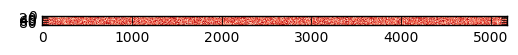

In [25]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm #Makes imageplotlib show the images inline #in Jupyter notebooks: 
%matplotlib inline 
Width=200
Height=200

I = weights[0].reshape(100,5184)
plt.imshow(I, cmap = cm.Reds) 


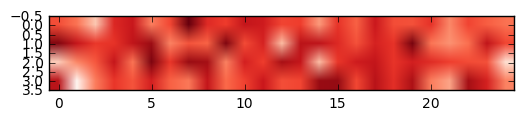

In [26]:
#the ones he wants from us are the next three
II = weights[1].reshape(4,25) 
plt.imshow(II, cmap = cm.Reds) 



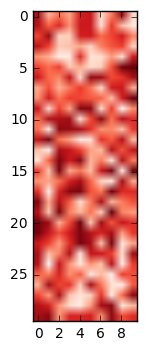

In [27]:
III = weights[2].reshape(30,10) 
plt.imshow(III, cmap = cm.Reds) 



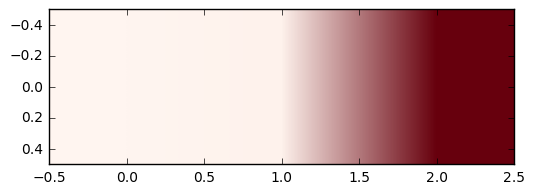

In [28]:
IIII = weights[3].reshape(1,3) 
plt.imshow(IIII, cmap = cm.Reds) 

# 3. A more difficult classification problem

In [29]:
from keras.utils import np_utils
from keras.layers import Flatten,Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.optimizers import SGD,Adam
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [30]:
#Using Linear classifier on noisy data
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)

Y_train_categ = np_utils.to_categorical(Y_train, 3)

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_2 = Sequential()
model_2.add(Dense(100, activation="tanh",input_shape=(5184,)))
model_2.add(Dense(3, activation="softmax"))
model_2.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

model_2.fit(X_train, Y_train_categ, epochs=15, batch_size=50)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Epoch 1/15
1000/1000 [==============================] - 1s 566us/step - loss: 0.2838 - acc: 0.3350
Epoch 2/15
1000/1000 [==============================] - 0s 302us/step - loss: 0.2842 - acc: 0.3310
Epoch 3/15
1000/1000 [==============================] - 0s 299us/step - loss: 0.2842 - acc: 0.3150
Epoch 4/15
1000/1000 [==============================] - 0s 303us/step - loss: 0.2825 - acc: 0.3510
Epoch 5/15
1000/1000 [==============================] - 0s 298us/step - loss: 0.2824 - acc: 0.3510
Epoch 6/15
1000/1000 [==============================] - 0s 296us/step - loss: 0.2831 - acc: 0.3390
Ep

As we can see above using a simle linear classifier to noisy data does not yield a very good model. We will now need to add convolution layer to train the image data better

In [31]:
#Adding convolution layer

X_train=X_train.reshape(1000,72,72,1)
model_3 = Sequential()
#model(Reshape((81, 64)))
# now: model.output_shape ==
model_3.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72,72,1)))  
model_3.add(MaxPooling2D(pool_size=(2, 2))) 
model_3.add(Activation("relu"))
print(model_3.output_shape) 
model_3.add(Flatten()) 
#model.add(Dense(1000,activation='relu'))
print(model_3.output_shape) 
model_3.add(Dense(3,activation='softmax'))
model_3.compile(loss='mean_squared_error',optimizer=adam, metrics=['accuracy'])
print(model_3.output_shape) 
model_3.fit(X_train, Y_train_categ, epochs=10, batch_size=32)




(None, 34, 34, 16)
(None, 18496)
(None, 3)
Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3405 - acc: 0.3600
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1681 - acc: 0.6040
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1305 - acc: 0.7230
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1103 - acc: 0.7980
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0943 - acc: 0.8370
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0779 - acc: 0.8800
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0720 - acc: 0.8860
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0585 - acc: 0.9180
Epoch 9/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0525 - acc: 0.9320
Epoch 10/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0391 

As we can see the model has become much better with much lower loss and better accuracy. We will test this model to see the accuracy

In [33]:
[X_test, Y_test] = generate_test_set_classification()
X_test.shape

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


(300, 5184)

In [34]:
X_test=X_test.reshape(300,72,72,1)

Y_predict=model_3.predict(X_test)
model_3.evaluate(X_test,Y_test) #loss function3.5649e-06
#first value is the loss function (probably last value)
#second value is the metrics so accuracy here
Y_test
Y_predict


300/300 [==============================] - 1s 2ms/step


array([[3.55453312e-01, 4.95986640e-01, 1.48560092e-01],
       [2.83843786e-01, 2.82213867e-01, 4.33942348e-01],
       [2.69898862e-01, 6.40593588e-01, 8.95075127e-02],
       [6.21515393e-01, 7.01519996e-02, 3.08332592e-01],
       [7.20814802e-04, 9.97406185e-01, 1.87304325e-03],
       [5.18141256e-04, 9.99401331e-01, 8.05081145e-05],
       [9.54209268e-02, 2.99759377e-02, 8.74603093e-01],
       [3.72560084e-01, 6.29329905e-02, 5.64506829e-01],
       [2.24529281e-01, 6.24507964e-02, 7.13019907e-01],
       [4.76963520e-01, 5.16115725e-01, 6.92075444e-03],
       [5.14783785e-02, 3.39319780e-02, 9.14589643e-01],
       [4.76202276e-03, 9.92543817e-01, 2.69410945e-03],
       [1.34272622e-02, 1.37534039e-02, 9.72819388e-01],
       [4.44015443e-01, 8.96983519e-02, 4.66286302e-01],
       [1.44668417e-02, 1.78661924e-02, 9.67666924e-01],
       [6.71873689e-02, 9.29613471e-01, 3.19910166e-03],
       [8.57776555e-04, 9.99070466e-01, 7.17995208e-05],
       [6.55932911e-03, 9.90179

In [35]:
score,acc=model_3.evaluate(X_test,Y_test)
print('Test Score:', score)
print('Test Accuracy:', acc)

300/300 [==============================] - 1s 2ms/step
Test Score: 0.09495466351509094
Test Accuracy: 0.7966666674613953


## 4. Regression Problem

In [36]:
#Create regression training set

[X_train, Y_train] = generate_dataset_regression(2000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


In [37]:
X_train.shape

(2000, 5184)

In [38]:
Y_train.shape

(2000, 6)

In [39]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Normalizing data in Y to make sure all the values x and y co-ordinates are sorted in the same order so the model can train better

In [40]:
#We will first divide the Y train in x and y co-ordinates, sort the x co-ordinates and make sure we have pairs of y for same x

In [41]:
list_1_train=Y_train[:,[0,2,4]]
list_2_train=Y_train[:,[1,3,5]]

In [42]:
#Here we will sort the x co-ordinates and make sure y co-ordinates are sorted in the same way using zip function
for i in range(len(list_1_train)):
    list_1_train[i,], list_2_train[i,] = zip(*sorted(zip(list_1_train[i,], list_2_train[i,])))
    

In [43]:
# Below we will check if the sorting happened as we desired so we can move ahead with changing our Y_train

In [44]:
list_1_train[0:5,]

array([[0.31926686, 0.56522072, 0.71986584],
       [0.05955469, 0.45803212, 0.5897701 ],
       [0.08891649, 0.09971599, 0.91636717],
       [0.00729675, 0.00743465, 0.11420951],
       [0.15763227, 0.25478599, 0.31443732]])

In [45]:
list_2_train[0:5,]

array([[0.97619732, 0.02423682, 0.92000602],
       [0.72586894, 0.09377698, 0.4675181 ],
       [0.13967046, 0.65815732, 0.44684067],
       [0.46047766, 0.33013019, 0.28545202],
       [0.75406049, 0.21114498, 0.76348601]])

In [46]:
Y_train[0:5]

array([[0.71986584, 0.92000602, 0.31926686, 0.97619732, 0.56522072,
        0.02423682],
       [0.45803212, 0.09377698, 0.5897701 , 0.4675181 , 0.05955469,
        0.72586894],
       [0.09971599, 0.65815732, 0.08891649, 0.13967046, 0.91636717,
        0.44684067],
       [0.00743465, 0.33013019, 0.11420951, 0.28545202, 0.00729675,
        0.46047766],
       [0.25478599, 0.21114498, 0.15763227, 0.75406049, 0.31443732,
        0.76348601]])

In [47]:
# As we inspect the sorting order is correct, we will now sort the Y_train and Y test

for i in range(len(list_1_train)):
    for j in range(6):
        if j%2==0:
                a=int(j/2)
                Y_train[i,j]=list_1_train[i,a]
        else:
                b=int((j-1)/2)
                Y_train[i,j]=list_2_train[i,b]    
        

In [48]:
Y_train[0:5]

array([[0.31926686, 0.97619732, 0.56522072, 0.02423682, 0.71986584,
        0.92000602],
       [0.05955469, 0.72586894, 0.45803212, 0.09377698, 0.5897701 ,
        0.4675181 ],
       [0.08891649, 0.13967046, 0.09971599, 0.65815732, 0.91636717,
        0.44684067],
       [0.00729675, 0.46047766, 0.00743465, 0.33013019, 0.11420951,
        0.28545202],
       [0.15763227, 0.75406049, 0.25478599, 0.21114498, 0.31443732,
        0.76348601]])

In [49]:
#Creating test data

[X_test, Y_test] = generate_test_set_regression()


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [50]:
Y_test.shape

(300, 6)

In [51]:
list_1_test=Y_test[0:300,[0,2,4]]

In [52]:
list_2_test=Y_test[0:300,[1,3,5]]

In [53]:
for i in range(len(list_1_test)):
    list_1_test[i,], list_2_test[i,] = zip(*sorted(zip(list_1_test[i,], list_2_test[i,])))

In [54]:
for i in range(len(list_1_test)):
    for j in range(6):
        if j%2==0:
                a=int(j/2)
                Y_test[i,j]=list_1_test[i,a]
        else:
                b=int((j-1)/2)
                Y_test[i,j]=list_2_test[i,b]    

In [55]:
Y_test[0:5,]

array([[0.36340393, 0.33217252, 0.67661723, 0.27556678, 0.94133439,
        0.93818117],
       [0.17839825, 0.77686033, 0.49350036, 0.81401674, 0.51306942,
        0.78858177],
       [0.23325432, 0.15415605, 0.32182751, 0.87390724, 0.5149824 ,
        0.45317341],
       [0.16213195, 0.84262262, 0.57681979, 0.58680997, 0.91139454,
        0.37708317],
       [0.73548441, 0.45606621, 0.88877703, 0.05455311, 0.90340186,
        0.74689834]])

In [56]:
##define base model
#def base_model():
model_6 = Sequential()
model_6.add(Conv2D(16,(5,5),activation = 'relu' , input_shape=(72,72,1)))
model_6.add(MaxPooling2D(pool_size=(2,2)))
model_6.add(Activation("relu"))
model_6.add(Flatten())
model_6.add(Dense(6))
model_6.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
    #return model

#seed=3
#np.random.seed(seed)

#scale = StandardScaler()
#X_train_1 = scale.fit_transform(X_train)
#X_test_1 = scale.transform(X_test)
#Y_train_1 = scale.fit_transform(Y_train)
#Y_test_1 = scale.transform(Y_test)


X_train = X_train.reshape(2000,72,72,1)

#clf = KerasRegressor(build_fn=base_model, nb_epoch=15, batch_size=32)

model_6.fit(X_train,Y_train,epochs=45,batch_size=80)



Epoch 1/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1804 - acc: 0.3840
Epoch 2/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0384 - acc: 0.5630
Epoch 3/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0274 - acc: 0.6170
Epoch 4/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0229 - acc: 0.6480
Epoch 5/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0200 - acc: 0.6655
Epoch 6/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0176 - acc: 0.7005
Epoch 7/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0159 - acc: 0.7010
Epoch 8/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0145 - acc: 0.7185
Epoch 9/45
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0135 - acc: 0.7285
Epoch 10/45
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0126 - acc: 0.7310
Epoch 11/45
2000/2000 [======

## This model is returning with much lower loss and a good accuracy we will now predict a shape on test dataset

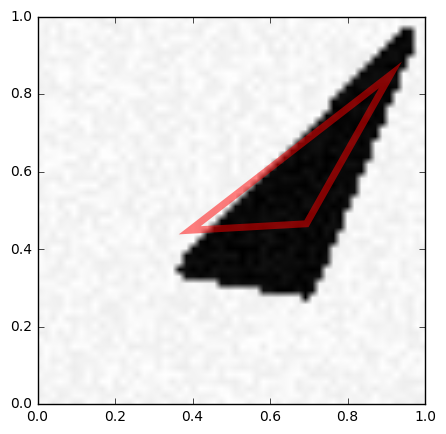

In [57]:
#clf.fit(X_train,Y_train)
#res = clf.predict(X_test.reshape(300,72,72,1))

Y_predict=model_6.predict(X_test.reshape(300,72,72,1))

 

visualize_prediction(X_test[0], Y_predict[0])
    
#visualize_prediction(X_test[0], res[0])


The model is not fitting the triangle very well. But this is better than model tried without the sorting way. This model can be made better by adding further layers of convolution and Dense network. We will try that below. 

## 5. Image Denoising 

In [148]:
#Creating functions to generate data with noise 

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_noisy(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noisy = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return [imdata,imdata_noisy]

def generate_a_rectangle_noisy(noise=100.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_noisy(figsize, U, V, noise)


def generate_a_disk_noisy(noise=100.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_noisy(figsize, U, V, noise)

def generate_a_triangle_noisy(noise=100.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata,imdata_noisy = generate_a_drawing_noisy(figsize, U, V, noise)
    return [imdata,imdata_noisy]





def generate_dataset_denoising(nb_samples, noise=100.0, free_location=False):
    # Getting im_size:
    x, x_n = generate_a_rectangle_noisy()
    im_size = x.shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise= np.zeros([nb_samples,im_size])
    #Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],X_noise[i]] = generate_a_rectangle_noisy(noise, free_location)
        elif category == 1: 
            [X[i],X_noise[i]] = generate_a_disk_noisy(noise, free_location)
        else:
            [X[i],X_noise[i]] = generate_a_triangle_noisy(noise, free_location)
        #Y[i] = category
    #X = (X + noise) / (255 + 2 * noise)
    return [X, X_noise]

#Function for generating test data 
def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, X_noise_test] = generate_dataset_denoising(300)
    return [X_test, X_noise_test]



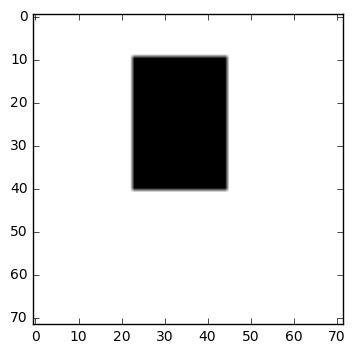

In [149]:
im,imn = generate_a_rectangle_noisy(100, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


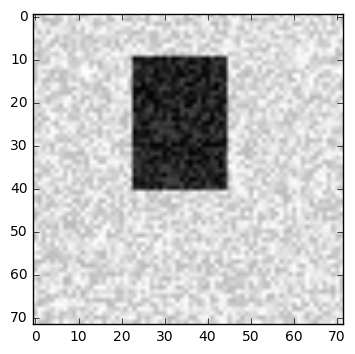

In [150]:
plt.imshow(imn.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [151]:
from keras.utils import np_utils
from keras.layers import Flatten,Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.layers import Dense, Activation

#add layers to model
model8 = Sequential()
#Using a single convolutional layer with 16 5x5 filters- we will first try with this as tried  before and then we can cme back and add more layers if required
model8.add(Conv2D(16,(5,5), activation='relu', input_shape=(72,72,1)))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Activation("relu"))
model8.add(Flatten())
model8.add(Dense(6))
model8.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [152]:
from keras import Input
input_img = Input(shape=(72, 72, 1))

## Using Autoencoder Hourglass technique to denoise the data

Below we will create the autoencoder function and specify encoding and decosing criterias. We keep trying with different sets of Convolutional network and fix one one which matches the input and output set. 

In [153]:

#Implementing the encoded function
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

#Implementing the decoded function
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3, 3), padding='same')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 72, 72, 128)       1280      
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 36, 36, 64)        73792     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 18, 18, 32)        18464     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 9, 9, 32)          0         
__________

In [154]:
#  this model maps an input to its encoded representation -0.001
encoder = Model(input_img, encoded)

In [155]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [156]:
[X_training, X_training_noise] = generate_dataset_denoising(300,10)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


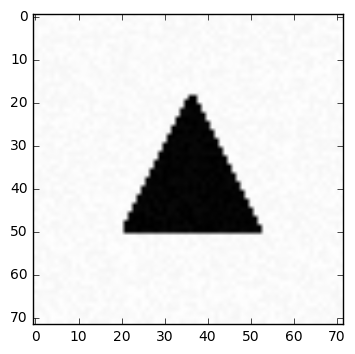

In [157]:
plt.imshow(X_training_noise[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [158]:
X_training=X_training/255
X_training_noise=X_training_noise/255
X_training_scaled= X_training.reshape(X_training.shape[0], 72, 72,1)
X_training_noise_scaled = X_training_noise.reshape(X_training_noise.shape[0], 72, 72,1)
train_history = autoencoder.fit(X_training_noise_scaled, X_training_scaled, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 25s 85ms/step - loss: 0.4047 - acc: 0.4518
Epoch 2/10
300/300 [==============================] - 27s 89ms/step - loss: 0.1468 - acc: 0.8145
Epoch 3/10
300/300 [==============================] - 26s 86ms/step - loss: 0.0983 - acc: 0.8923
Epoch 4/10
300/300 [==============================] - 27s 90ms/step - loss: 0.0761 - acc: 0.9270
Epoch 5/10
300/300 [==============================] - 28s 92ms/step - loss: 0.0609 - acc: 0.9453
Epoch 6/10
300/300 [==============================] - 27s 91ms/step - loss: 0.0480 - acc: 0.9574
Epoch 7/10
300/300 [==============================] - 27s 90ms/step - loss: 0.0378 - acc: 0.9656
Epoch 8/10
300/300 [==============================] - 27s 91ms/step - loss: 0.0318 - acc: 0.9700
Epoch 9/10
300/300 [==============================] - 27s 90ms/step - loss: 0.0277 - acc: 0.9737
Epoch 10/10
300/300 [==============================] - 27s 90ms/step - loss: 0.0249 - acc: 0.9769


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


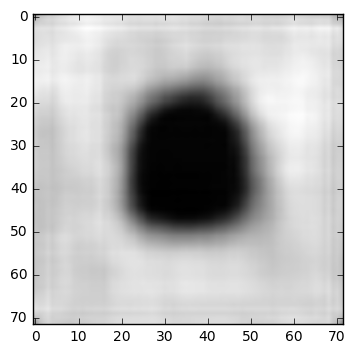

In [159]:
[X_test, X_noise_test] = generate_test_set_denoising()
X_noise_test/=255
X_test_re= X_test.reshape(X_test.shape[0], 72, 72,1)
X_noise_test_re = X_noise_test.reshape(X_noise_test.shape[0], 72, 72,1)
pred = autoencoder.predict(X_noise_test_re)S
pred*=255
plt.imshow(pred[0].reshape(72, 72), cmap='gray')

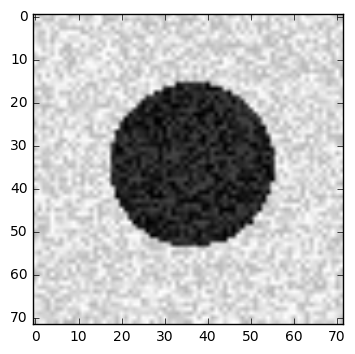

In [160]:
plt.imshow(X_noise_test_re[0].reshape(72, 72), cmap='gray')